In [2]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

ModuleNotFoundError: No module named 'pandas'

In [38]:
df = pd.read_csv('C:/Users/Bayu Lobi/Documents/Semester 6/Machine Learning/Prediksi_Emas/DataEmas.csv')
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,07/05/2025,"3.395,10","3.409,27","3.409,94","3.368,05","169,37K","-0,41%"
1,06/05/2025,"3.409,06","3.345,70","3.444,50","3.332,10","36,71K","2,61%"
2,05/05/2025,"3.322,30","3.247,10","3.346,70","3.243,10","184,90K","2,44%"
3,02/05/2025,"3.243,30","3.247,60","3.277,00","3.229,50","210,99K","0,65%"
4,01/05/2025,"3.222,20","3.299,00","3.300,60","3.209,40","214,69K","-2,92%"


In [39]:
# Set Date as index
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True)
df = df.set_index('Tanggal')

In [40]:
# Check dataframe shape
df.shape

(1376, 6)

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1376 entries, 2025-05-07 to 2020-01-02
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Terakhir    1376 non-null   object
 1   Pembukaan   1376 non-null   object
 2   Tertinggi   1376 non-null   object
 3   Terendah    1376 non-null   object
 4   Vol.        1374 non-null   object
 5   Perubahan%  1376 non-null   object
dtypes: object(6)
memory usage: 75.2+ KB


In [42]:
df.isnull().sum()

Terakhir      0
Pembukaan     0
Tertinggi     0
Terendah      0
Vol.          2
Perubahan%    0
dtype: int64

In [43]:
# 2. Ganti titik jadi kosong, koma jadi titik (untuk angka)
def to_float(x):
    return float(x.replace('.', '').replace(',', '.'))

df['High'] = df['Tertinggi'].apply(to_float)
df['Low'] = df['Terendah'].apply(to_float)

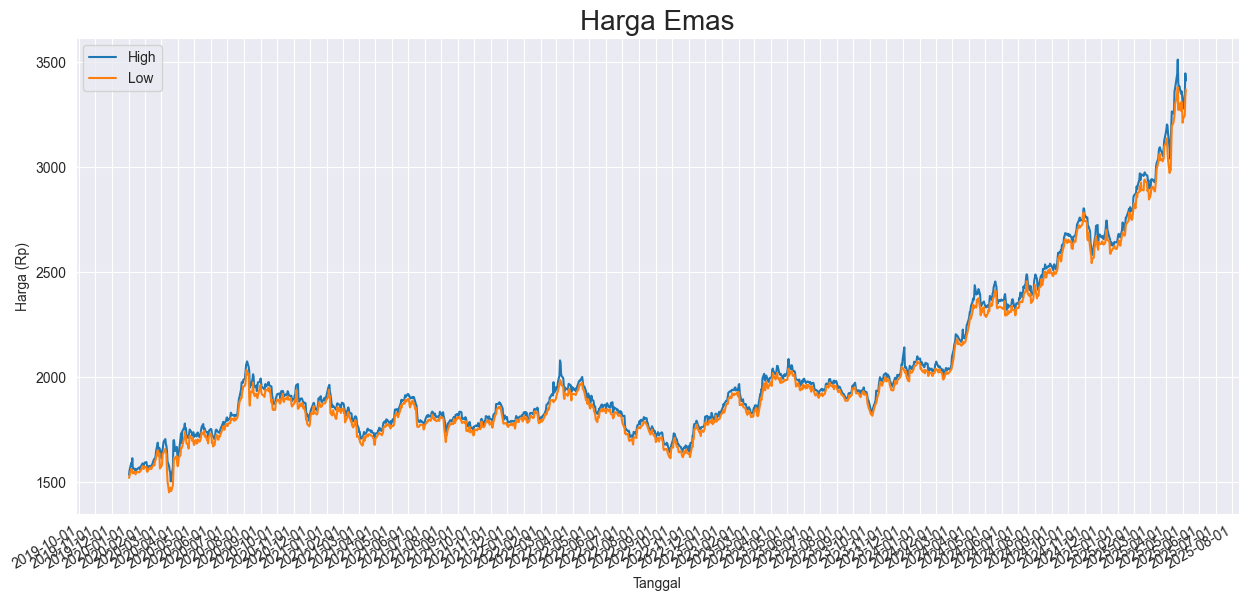

In [45]:
sns.set_style('darkgrid')
plt.figure(figsize=(15,7))

# Format tanggal
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

# Gunakan index datetime untuk sumbu X
x_dates = df.index

# Plot harga tertinggi dan terendah
plt.plot(x_dates, df['High'], label='High')
plt.plot(x_dates, df['Low'], label='Low')

# Label dan Judul
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.title("Harga Emas", fontsize=20)
plt.legend()

# Rotasi tanggal otomatis
plt.gcf().autofmt_xdate()
plt.show()

In [46]:
def to_float(x):
    return float(x.replace('.', '').replace(',', '.'))

# Rename dan convert kolom
df['Open'] = df['Pembukaan'].apply(to_float)
df['Close'] = df['Terakhir'].apply(to_float)

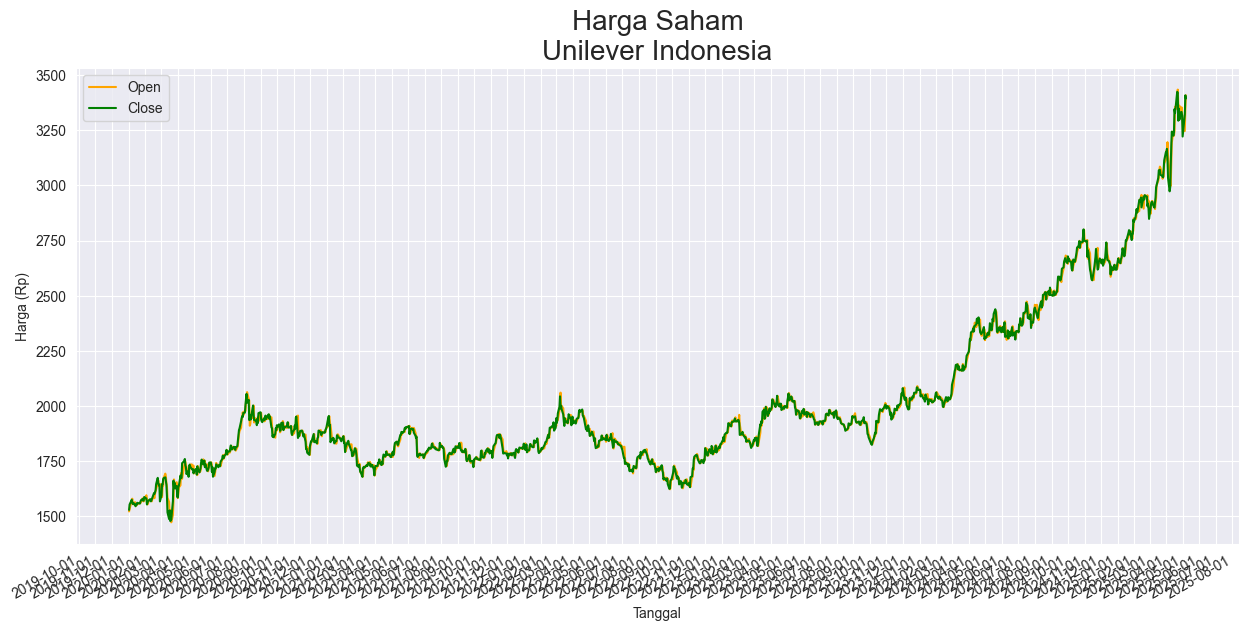

In [47]:
plt.figure(figsize=(15, 7))

# Format sumbu X (tanggal)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # 1 bulan sekali

# Plot harga pembukaan dan penutupan
plt.plot(df.index, df['Open'], label='Open', color='orange')
plt.plot(df.index, df['Close'], label='Close', color='green')

# Label dan Judul
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rp)')
plt.title("Harga Saham\nUnilever Indonesia", fontsize=20)
plt.legend()

# Format tanggal agar tidak bertabrakan
plt.gcf().autofmt_xdate()
plt.show()

In [48]:
#MinMaxScaler
ms = MinMaxScaler()
df['Close_ms'] = ms.fit_transform(df[['Close']])

In [49]:
def split_data(df, train_size):
  size = int(len(df) * train_size)
  train, test = df.iloc[0:size], df.iloc[size:len(df)]
  return train, test

In [50]:
train, test = split_data(df['Close_ms'], 0.8) #80% Train

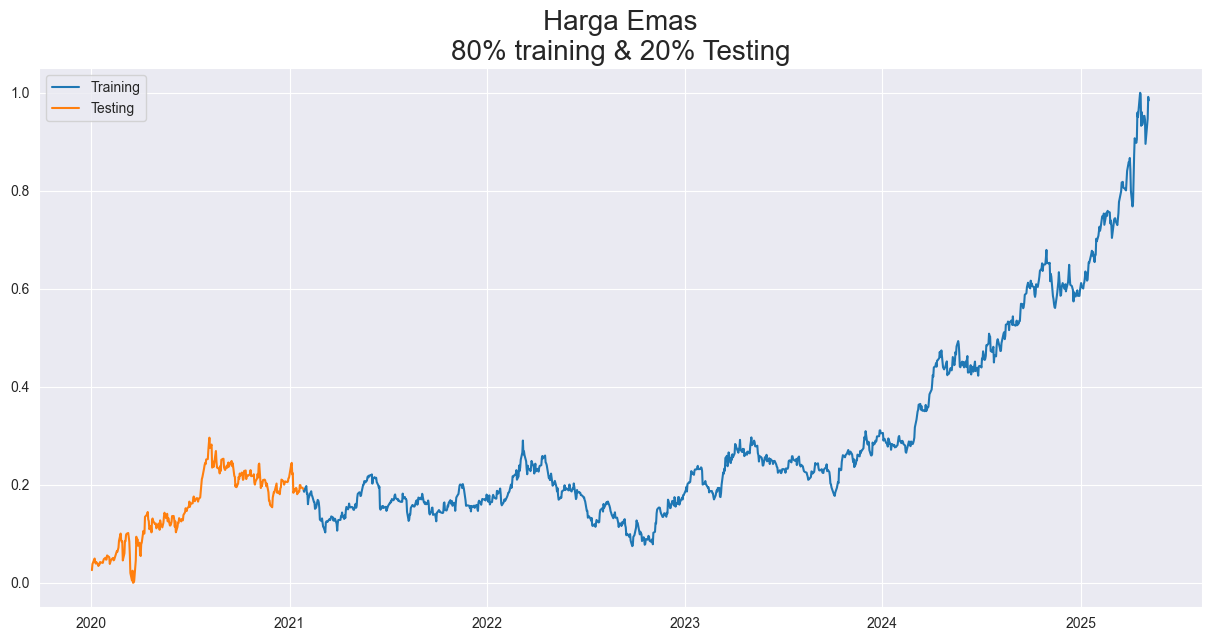

In [51]:
plt.figure(figsize=(15,7))
plt.plot(train)
plt.plot(test)
plt.legend(labels=['Training', 'Testing'])
plt.title('Harga Emas\n80% training & 20% Testing', fontsize=20)
plt.show()

In [52]:
def split_target(df, look_back=1):
    X, y = [], []
    for i in range(len(df) - look_back):
        a = df[i:(i + look_back), 0]
        X.append(a)
        y.append(df[i + look_back, 0])
    return np.array(X), np.array(y)

In [53]:
X_train, y_train = split_target(train.values.reshape(len(train), 1))
X_test, y_test = split_target(test.values.reshape(len(test), 1))

In [54]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [55]:
model = Sequential([LSTM(128, input_shape=(1, 1), return_sequences=True),
                    Dropout(0.2),
                    LSTM(64),
                    Dropout(0.2),
                    Dense(32, activation='relu'),
                    Dense(1)])

c:\Users\Bayu Lobi\Documents\Semester 6\Machine Learning\Prediksi_Emas\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [56]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,081 (461.25 KB)

 Trainable params: 118,081 (461.25 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              metrics=["mae"],
              loss=tf.keras.losses.Huber())

In [82]:
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    shuffle=False,
                    callbacks=[Callback()])

NameError: name 'Callback' is not defined

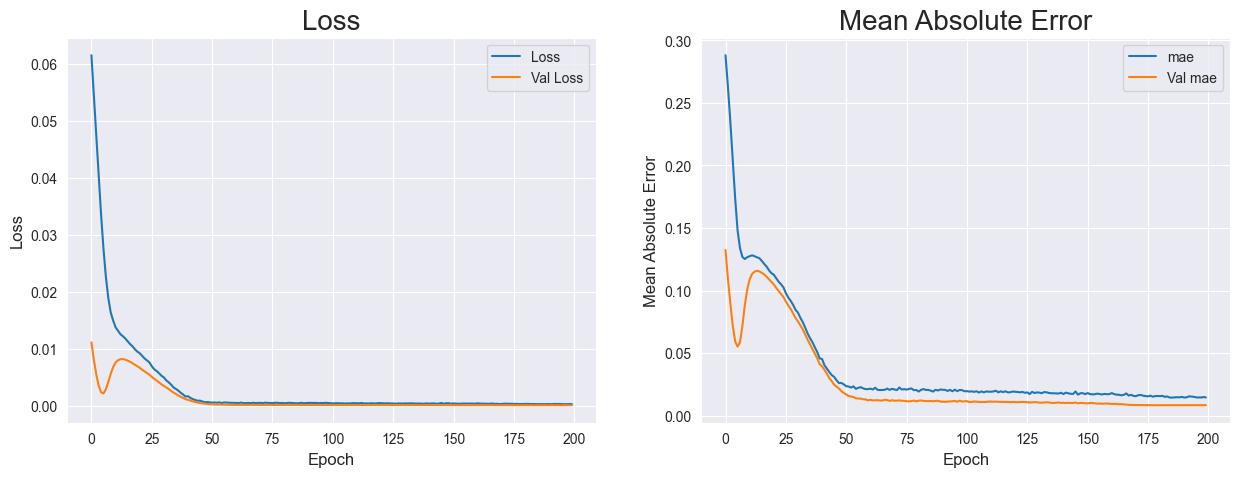

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# Loss
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['Loss','Val Loss'])
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss', fontsize=20)

# MAE
ax2.plot(history.history['mae'])
ax2.plot(history.history['val_mae'])
ax2.legend(['mae','Val mae'])
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Mean Absolute Error', fontsize=12)
ax2.set_title('Mean Absolute Error', fontsize=20)
plt.show()

In [ ]:
print(df.columns)

Index(['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%',
       'High', 'Low', 'Open', 'Close', 'Close_ms'],
      dtype='object')


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


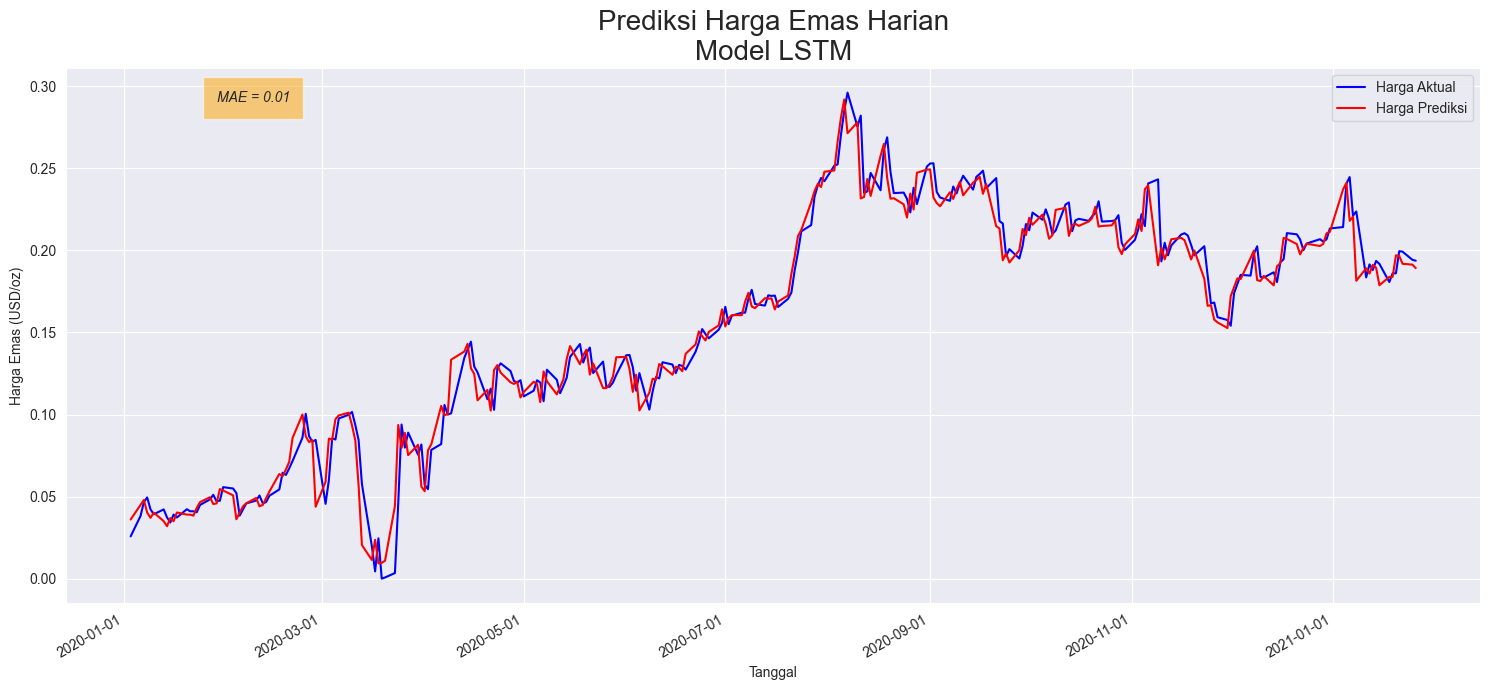

In [ ]:


# (Model training dan X_test, y_test tetap seperti sebelumnya)

# Prediksi
pred = model.predict(X_test)
y_pred = np.array(pred).reshape(-1)

# Plot
plt.figure(figsize=(15, 7))
plt.plot(test.index[:-1], y_test, color='blue', label='Harga Aktual')
plt.plot(test.index[:-1], y_pred, color='red', label='Harga Prediksi')

mae = mean_absolute_error(y_test, y_pred)
plt.text(test.index[-20], max(y_test) * 0.98, f"MAE = {mae:.2f}", 
         style='italic', bbox={'facecolor': 'orange', 'alpha': 0.5, 'pad': 10})

plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD/oz)')  # ← Ganti label satuan di sini
plt.title('Prediksi Harga Emas Harian\nModel LSTM', fontsize=20)

plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
%pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('MAE: ', mae)
print('RSME: ', rmse)
print('MAPE: ', mape)

TypeError: got an unexpected keyword argument 'squared'